# CMIP6 Historical Prediction

In [6]:
import os
import sys
import xarray as xr
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)
from IndexDrivers import (
    AnomaliesIndex,
    MaxIndex, 
    calculate_anomalies
)
from PredictorsDrivers import (
    Predictor
)

c:\Users\marti\Desktop\data\hw_extra


## Load cmip6 drivers

In [3]:
import tensorflow as tf
import os
import numpy as np
import random
import keras
SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    keras.utils.set_random_seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import TimeSeriesSplit

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, GRU, Conv1D, Flatten, Reshape

from sklearn.svm import SVR
from xgboost import XGBRegressor
import sys
from catboost import CatBoostRegressor


In [4]:
folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from Predictions import (
    PredictionExperiment,
    PredictionModel,
    SERA,
    sera_objective,
    piecewise_linear_phi_np
)

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load Data

In [30]:
path_drivers = "data/03_primary/drivers/dfs_dict.pickle"
with open(path_drivers, 'rb') as handle:
    models_df = pickle.load(handle)

In [31]:
hws_chile = pd.read_csv("data/local_data/monthly/hws_chile_library.csv")

hws_chile["time"] = pd.to_datetime(hws_chile["Unnamed: 0"],format='%Y-%m')
hws_chile.set_index('time', inplace=True)
hws_chile.drop(columns="Unnamed: 0", inplace=True)
hws_chile

hwn  hwf  hwd       hwm       hwa
time                                         
1971-01-01  0.0  0.0  0.0  0.000000  0.000000
1971-02-01  0.2  0.7  0.7  0.447148  0.807169
1971-03-01  0.0  0.0  0.0  0.000000  0.000000
1971-04-01  0.2  0.6  0.6  0.637038  0.982249
1971-05-01  0.1  0.3  0.3  0.555671  0.901254
...         ...  ...  ...       ...       ...
2023-08-01  0.3  1.0  1.0  0.902918  1.456688
2023-09-01  0.0  0.0  0.0  0.000000  0.000000
2023-10-01  0.1  0.3  0.3  0.062737  0.077569
2023-11-01  0.0  0.0  0.0  0.000000  0.000000
2023-12-01  0.1  0.6  0.6  0.077252  0.163605

[636 rows x 5 columns]

In [32]:
era5_df = pd.concat((models_df["ERA5"],hws_chile),axis=1)
era5_df

nino12    nino34  anom_wind_cl_raco  anom_wind_cl_puelche   
time                                                                      
1971-01-01 -1.928113 -1.640253           0.006237              1.624297  \
1971-02-01 -2.979414 -1.713375          -0.288501              0.221068   
1971-03-01 -3.288180 -2.059431          -0.232439              0.302271   
1971-04-01 -2.543985 -2.459558          -0.485039             -0.753484   
1971-05-01 -1.714362 -2.507134          -0.089548              0.699281   
...              ...       ...                ...                   ...   
2023-08-01  2.723302  1.550383           1.282423              1.932909   
2023-09-01  2.123090  1.722627           0.850378              1.987928   
2023-10-01  1.840521  1.741871          -0.057451             -0.161683   
2023-11-01  1.625754  1.960339           0.096582              1.173807   
2023-12-01  1.109014  2.099410          -0.348814             -1.820655   

            anom_wind_pressure  anom_ta_cl  anom_pdo  anom_psl_sam_40   
time                                                                    
1971-01-01         -155.360306    1.249381  0.997573      -112.387703  \
1971-02-01          -98.484497   -0.026722  0.767220        57.690361   
1971-03-01          -77.386848   -0.150289  0.633572         6.743707   
1971-04-01          198.601791   -0.788936  0.562198       -70.511070   
1971-05-01          185.134171    0.501217  0.420079      -178.369583   
...                        ...         ...       ...              ...   
2023-08-01         -374.929413    2.065721  1.704082       -33.429050   
2023-09-01         -178.303970    1.922226  2.295783        29.182522   
2023-10-01           24.046869   -0.402164  2.689852       312.206818   
2023-11-01         -339.330139    0.945060  2.757317       124.789513   
2023-12-01          303.737122   -1.503564  2.452650       269.578552   

            anom_psl_sam_65  anom_dmi_east  ...  longitude       pressure   
time                                        ...                             
1971-01-01       341.377930       0.051705  ...     255.00  102347.242188  \
1971-02-01        51.769032      -0.038294  ...     255.00  102348.992188   
1971-03-01      -146.034164      -0.249040  ...     269.00  102237.007812   
1971-04-01       233.869843      -0.472573  ...     271.75  102222.132812   
1971-05-01       701.905396      -0.592277  ...     293.00  102046.421875   
...                     ...            ...  ...        ...            ...   
2023-08-01       154.142227       0.257379  ...     293.00  102131.015625   
2023-09-01       252.867569       0.023470  ...     255.00  102677.593750   
2023-10-01      -144.109970      -0.294358  ...     255.00  102781.796875   
2023-11-01        80.167175      -0.467022  ...     255.00  102752.578125   
2023-12-01      -609.298462      -0.471782  ...     260.50  102704.679688   

            high_low_difference  adv_blob  adv_chile  hwn  hwf  hwd       hwm   
time                                                                            
1971-01-01           -67.718750 -1.075192   5.139239  0.0  0.0  0.0  0.000000  \
1971-02-01            36.468750  0.878110   0.437056  0.2  0.7  0.7  0.447148   
1971-03-01            64.906250 -3.049048  -0.064510  0.0  0.0  0.0  0.000000   
1971-04-01           191.304688  0.137372  -0.576733  0.2  0.6  0.6  0.637038   
1971-05-01            49.265625  0.105984  -0.972252  0.1  0.3  0.3  0.555671   
...                         ...       ...        ...  ...  ...  ...       ...   
2023-08-01           -88.976562 -2.776886  -0.530017  0.3  1.0  1.0  0.902918   
2023-09-01           -98.132812 -0.182294   3.426786  0.0  0.0  0.0  0.000000   
2023-10-01           -85.257812 -1.519804  -1.120164  0.1  0.3  0.3  0.062737   
2023-11-01          -210.367188  1.716634   1.758876  0.0  0.0  0.0  0.000000   
2023-12-01           -60.773438 -0.719822  -0.454558  0.1  0.6  0.6  0.077252   

                 hwa  
time     

## Predict by season

In [35]:
indices_of_interest = list(hws_chile.columns)
era5_trained_models = {}
bounds = (-1.1692892810242344, -0.30647585455315646, 3.0, 6.499969486244418)
loss_fn=SERA(bounds=bounds,T=100, initial_weight=0.1, fn="piecewise2")
models_predicted = {}

for i in range(1,13):
    df_season = era5_df[era5_df.index.month==i]
    cnn_rnn_model = Sequential([
            Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(era5_df.columns) - len(indices_of_interest))),
            Reshape((1, 16)),  # Back to time dimension
            SimpleRNN(8, activation="tanh"),
            Dropout(0.1),
            Dense(len(indices_of_interest))
        ])
    pred = PredictionModel(df_season, i, indices_of_interest, cnn_rnn_model, name_regressor="CNNRNN16",loss_fn=loss_fn)
    pred.compile_keras_model()
    
    y_train, y_pred_train = pred.train(5)

    for name, df in models_df.items():
        if i==1:
            models_predicted[name] = pd.DataFrame()
        df_target = df[df.index.month==i]
        df_target = df_target[(df_target.index.year >=1972) & (df_target.index.year <= 2014)]
        df_target[indices_of_interest] = df_season[indices_of_interest]
        target, features = pred.form_matrix(df_target)
        predicted = pd.DataFrame(pred.regressor.predict(pred.reshape_for_keras(target[features]))).rename(columns={i: label for i,label in enumerate(indices_of_interest)})
        predicted["Date"] = df_target.index
        predicted.set_index("Date",inplace=True)
        models_predicted[name] = pd.concat((models_predicted[name],predicted),axis=0)
        


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 0s/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 3ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


In [63]:
temp_df = pd.DataFrame()
for name, df in models_predicted.items():
    temp_df = pd.concat((temp_df, df), axis=1)

models_predicted["mean"] = pd.DataFrame(columns=models_predicted["ERA5"].columns,index=df.index)
for col in np.unique(temp_df.columns):
    models_predicted["mean"][col] = temp_df[col].mean(axis=1)
models_predicted["mean"]

hwn       hwf       hwd       hwm       hwa
Date                                                        
1972-01-01  0.053032 -0.038509  0.171622  0.406828  0.252667
1973-01-01  0.079564 -0.182298  0.039195  0.184158  0.264005
1974-01-01  0.203031  0.003214 -0.104791  0.289089  0.419705
1975-01-01  0.153572 -0.140925   0.00167  0.159342   0.14688
1976-01-01 -0.027924 -0.233884 -0.132353  0.207144  -0.05017
...              ...       ...       ...       ...       ...
2010-12-01 -0.090385  0.102986  0.208086 -0.108185  -0.21458
2011-12-01   0.55144  0.393923  0.410818  0.235166  0.415076
2012-12-01  0.578738  0.623646  0.507851  0.121245  0.623283
2013-12-01  0.753239  0.748173  0.662217  0.340039  0.755147
2014-12-01  0.564018  0.626061  0.496905  0.256215  0.456288

[516 rows x 5 columns]

In [ ]:
models_predicted["meteochile"] = era5_df[(era5_df.index.year >= 1972) & (era5_df.index.year <=2014)][indices_of_interest]

In [96]:
del models_predicted["meteochile"]

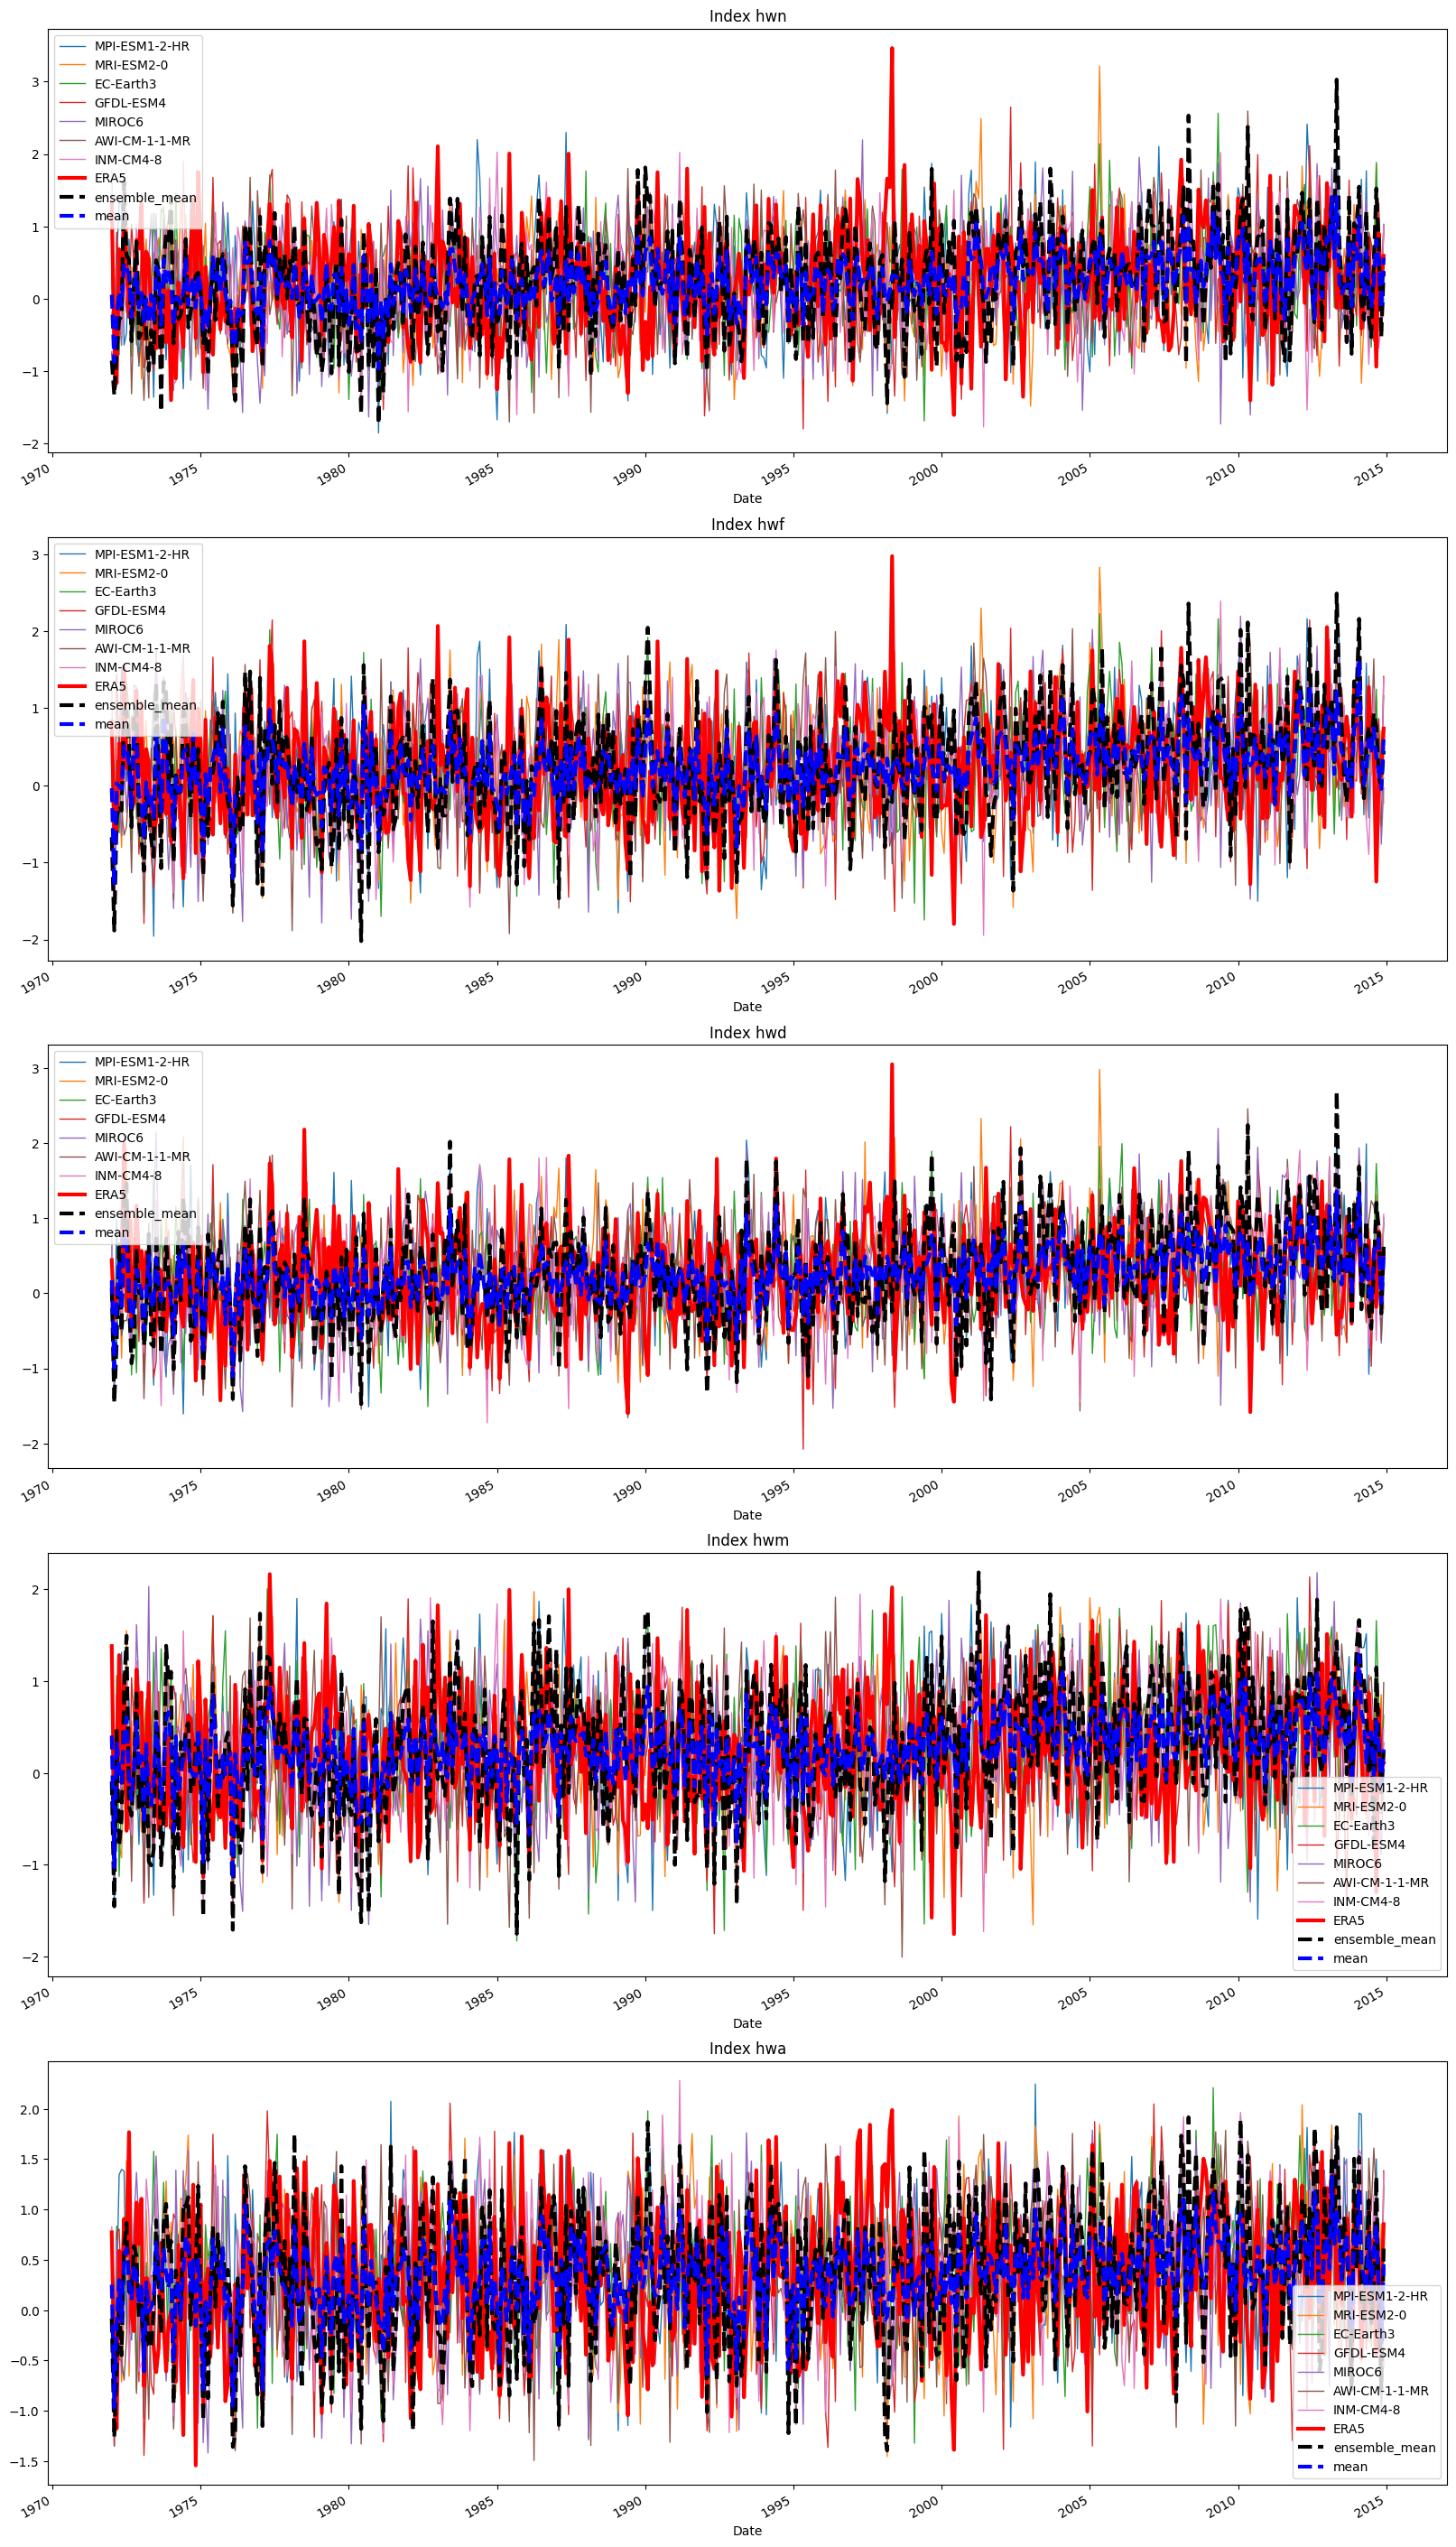

In [97]:
fig, axs = plt.subplots(5, figsize=(20, 40))
for i, index in enumerate(indices_of_interest):
    for model_name in models_predicted.keys():
        if model_name == "meteochile":
            models_predicted[model_name].plot(y=index, ax=axs[i], lw=3, c="black", label="meteochile")
        elif model_name == "ERA5":
            models_predicted[model_name].plot(y=index, ax=axs[i], lw=3, c="red", label=model_name)
        elif model_name == "ensemble_mean":
            models_predicted[model_name].plot(y=index, ax=axs[i], lw=3, c="black", linestyle="--", label=model_name)
        elif model_name == "mean":
            models_predicted[model_name].plot(y=index, ax=axs[i], lw=3, c="blue", linestyle="--", label=model_name)
        else:
            models_predicted[model_name].plot(y=index, ax=axs[i], lw=1, label=model_name)
    axs[i].set_title(f"Index {index}")

In [98]:
models_predicted["mean"] = models_predicted["mean"].astype(np.float64)

In [99]:
models_predicted_yearly = {}
models_predicted_decadal = {}
for name, df in models_predicted.items():
    df = df.sort_index()
    df["decade"] = (df.index.year // 10) * 10
    df["year"] = df.index.year

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if "time" in numeric_cols:
        numeric_cols.remove("time")
    if "Date" in numeric_cols:
        numeric_cols.remove("Date")
    agg_dict = {}
    for col in numeric_cols:
        if col in ['hwn', 'hwf']:
            agg_dict[col] = 'sum'
        elif col in ['hwd', 'hwa']:
            agg_dict[col] = 'max'
        else:
            agg_dict[col] = 'mean'
    
    df_year_grouped = df.groupby('year')[numeric_cols].agg(agg_dict)
    df_decadal_grouped = df.groupby('decade')[numeric_cols].agg(agg_dict)

    models_predicted_yearly[name] = df_year_grouped
    models_predicted_decadal[name] = df_decadal_grouped


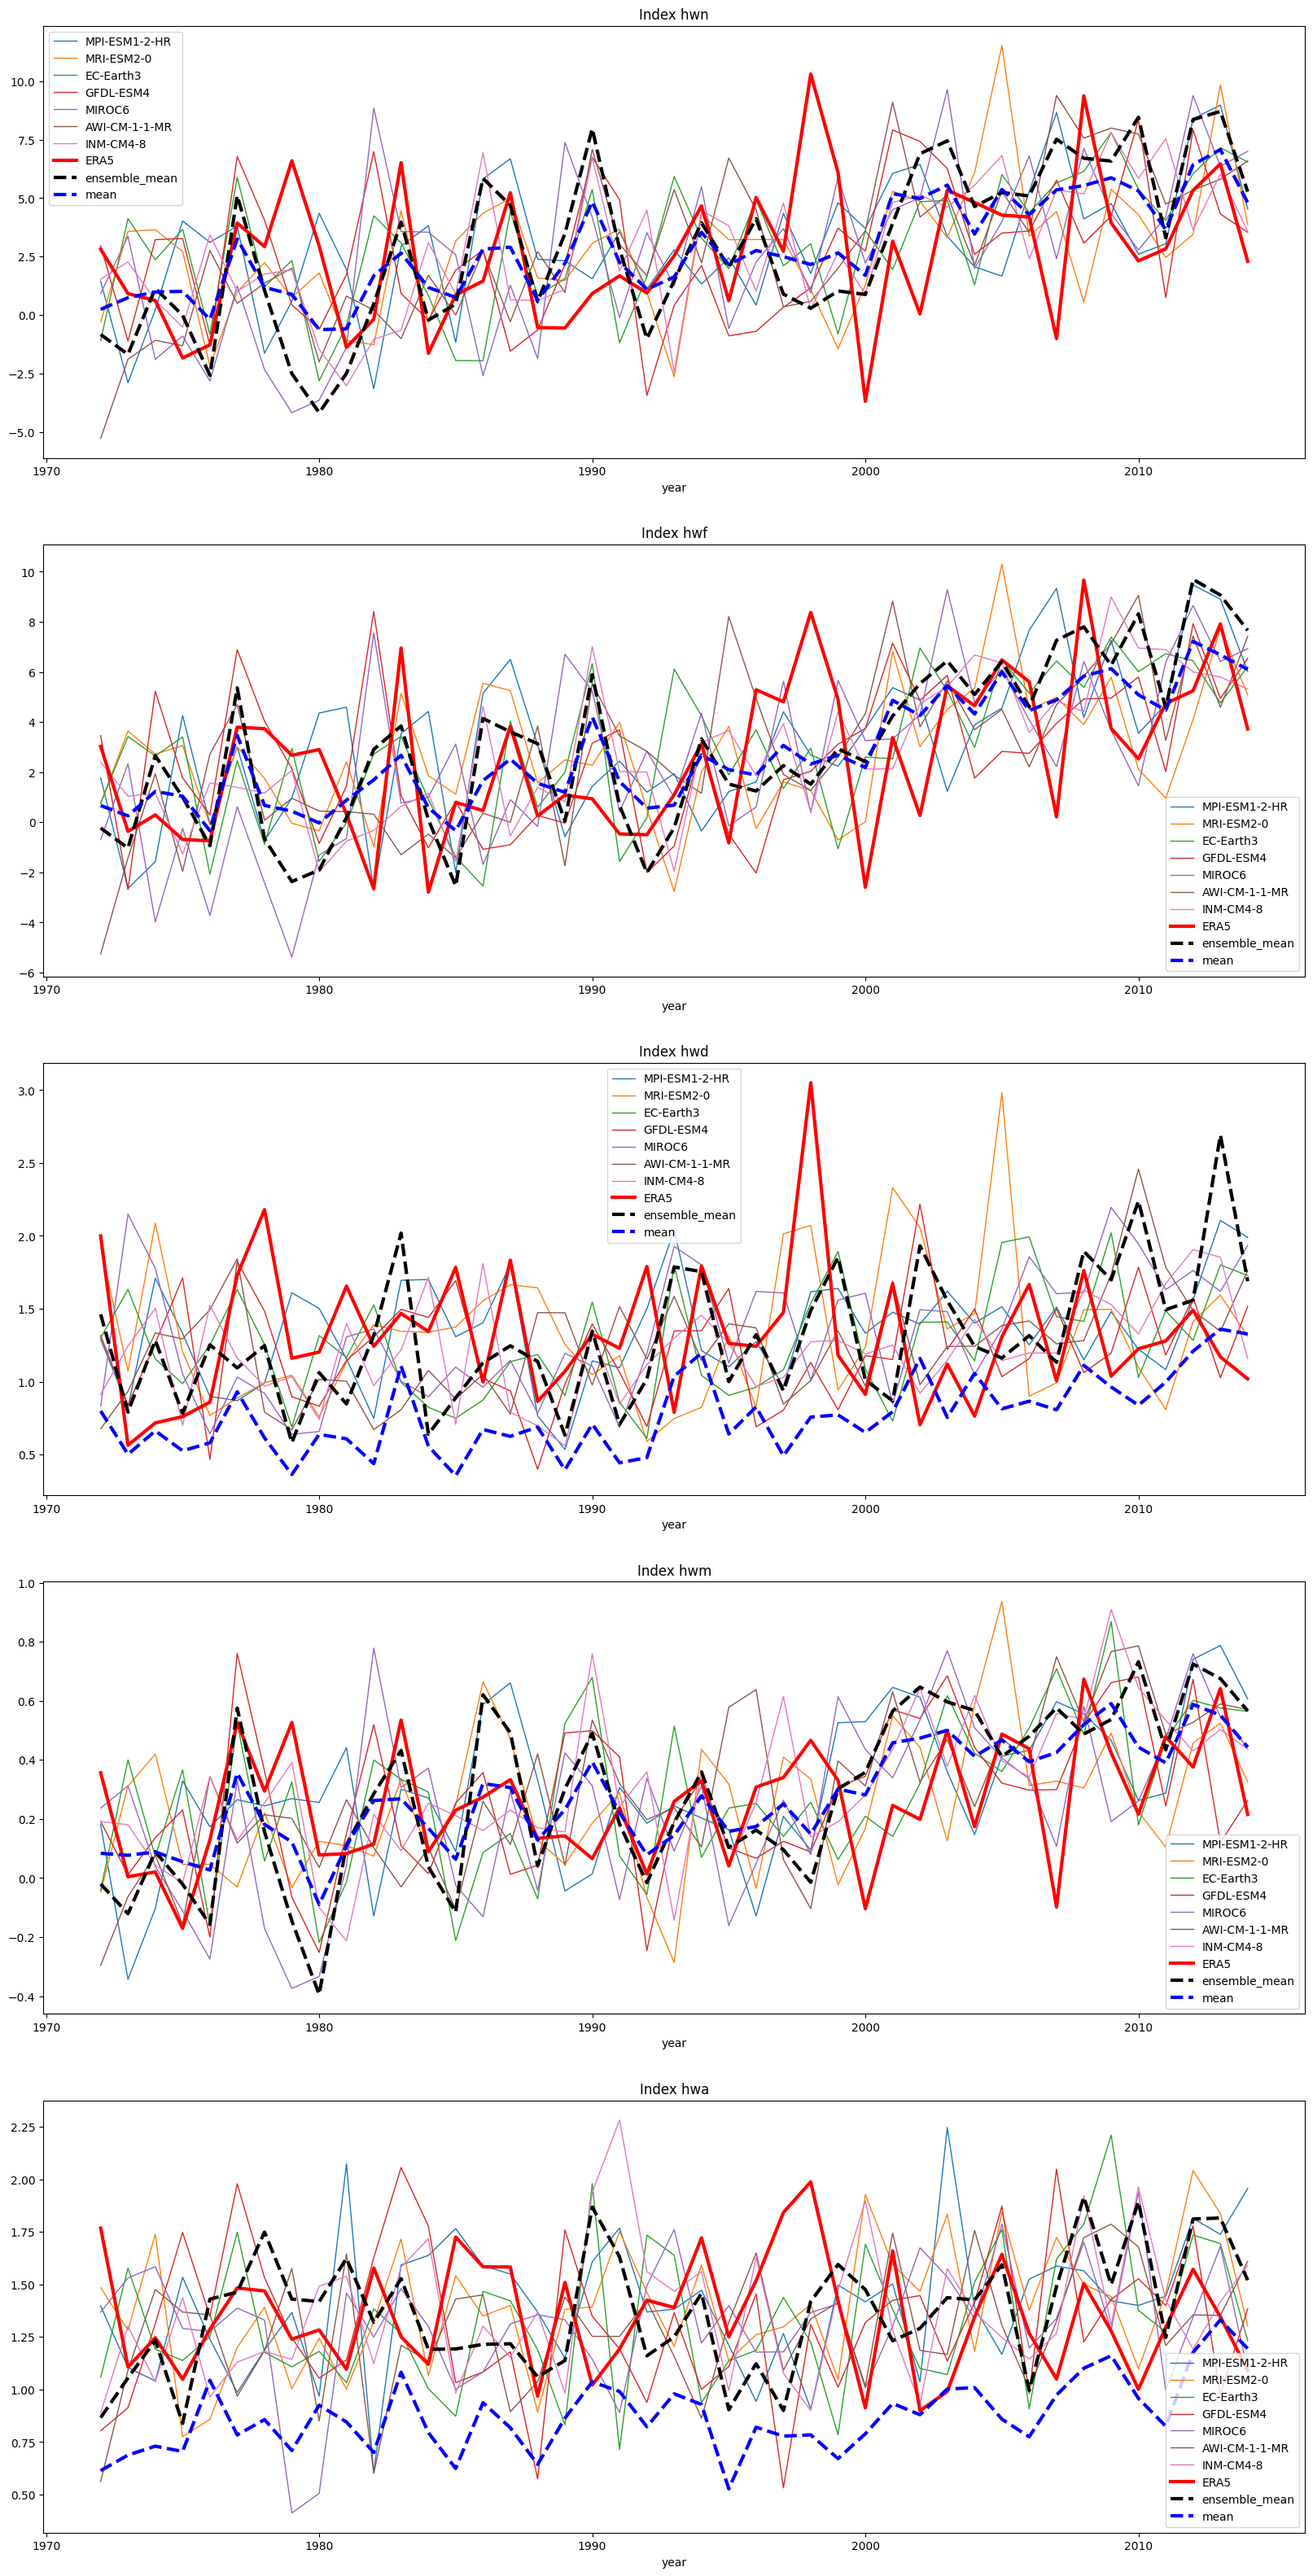

In [100]:
fig, axs = plt.subplots(5, figsize=(20, 40))
for i, index in enumerate(indices_of_interest):
    for model_name in models_predicted_yearly.keys():
        if model_name == "meteochile":
            models_predicted_yearly[model_name].plot(y=index, ax=axs[i], lw=3, c="black", label="meteochile")
        elif model_name == "ERA5":
            models_predicted_yearly[model_name].plot(y=index, ax=axs[i], lw=3, c="red", label=model_name)
        elif model_name == "ensemble_mean":
            models_predicted_yearly[model_name].plot(y=index, ax=axs[i], lw=3, c="black", linestyle="--", label=model_name)
        elif model_name == "mean":
            models_predicted_yearly[model_name].plot(y=index, ax=axs[i], lw=3, c="blue", linestyle="--", label=model_name)
        else:
            models_predicted_yearly[model_name].plot(y=index, ax=axs[i], lw=1, label=model_name)
    axs[i].set_title(f"Index {index}")